In [1]:
#!apt-get install git

### Original Notebook classifying all 4 classes:
- 0 : Glioma Tumor
- 1 : Meningioma Tumor
- 2 : No Tumor
- 3 : Pituitary Tumor

In [2]:
#!pip install opencv-python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [6]:
!nvidia-smi

Thu Jan  4 13:41:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We can see from the above output that Tensorflow is using the NVIDIA Tesla T4 GPU.

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
pituitary_tumor
no_tumor
meningioma_tumor


In [11]:
os.listdir(training_path)

['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

In [12]:
os.listdir(os.path.join(training_path,'pituitary_tumor'))[0:5]

['p (221).jpg', 'p (161).jpg', 'p (401).jpg', 'p (420).jpg', 'p (203).jpg']

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))

In [15]:
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

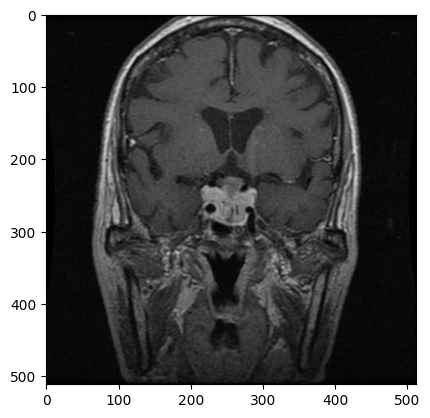

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [17]:
# for image_class in os.listdir(training_path):
#   for image in os.listdir(os.path.join(training_path, image_class)):
#     image_path = os.path.join(training_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

In [18]:
# for image_class in os.listdir(testing_path):
#   for image in os.listdir(os.path.join(testing_path, image_class)):
#     image_path = os.path.join(testing_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

# Loading data

Thr datset was already split into testing and training data so we do not need to define these later

In [19]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.
Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [20]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [21]:
Training_iterator

In [22]:
batch_training = Training_iterator.next()
# batch_testing = Testing_iterator.next()

In [23]:
len(batch_training)

2

len of 2 as the image is 1 dimension and the label is the  other

In [24]:
batch_training[0].shape

(32, 256, 256, 3)

In [25]:
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [26]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


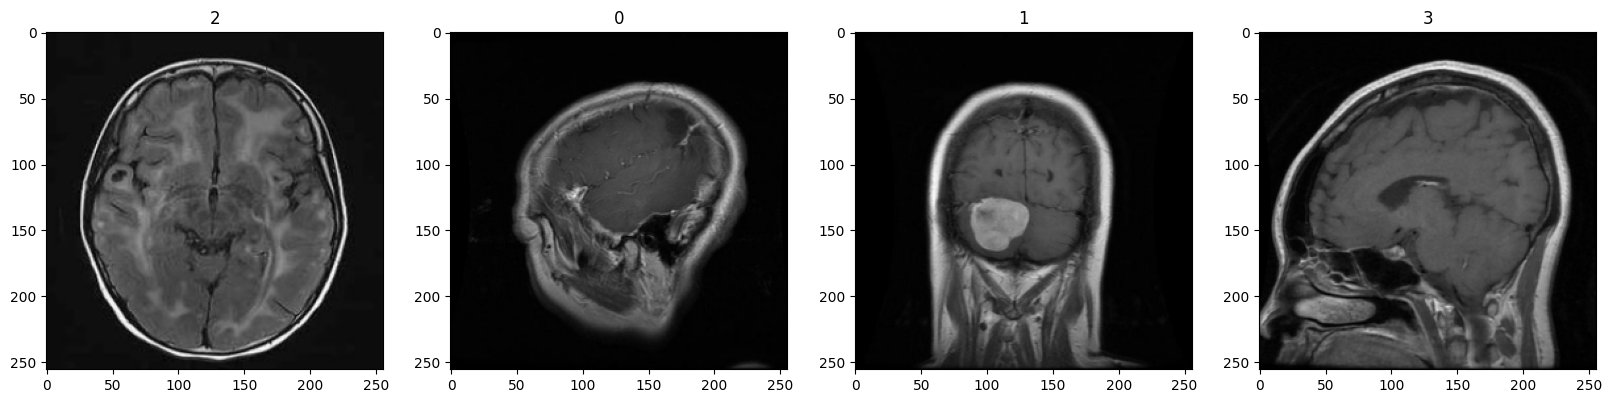

In [27]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


# Preprocessing Data

In [28]:
def augment_image(x, y):

     # Random left-right flip
    x = tf.image.random_flip_left_right(x)
    # Random up-down flip
    x = tf.image.random_flip_up_down(x)

     # Random rotation (90-degree increments)
    num_rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=num_rotations)

    # # Random zoom (zooming in or out)
    # zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    # crop_size = tf.cast(tf.cast(tf.shape(x)[0:2], dtype=tf.float32) * zoom_factor, dtype=tf.int32)
    # x = tf.image.central_crop(x, central_fraction=zoom_factor)
    # x = tf.image.resize(x, crop_size)
    # )
    # Add more augmentation functions as needed
    return x, y

In [29]:
num_classes = 4  # Adjust based on your number of classes

# Load the training dataset
Training_data = Training_data.map(augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))


# Load the validation dataset
Validation_data = Validation_data.map(augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


In [30]:
Training_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [31]:
batch_training = Training_data.as_numpy_iterator().next()
# batch_testing = Testing_data.as_numpy_iterator().next()


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


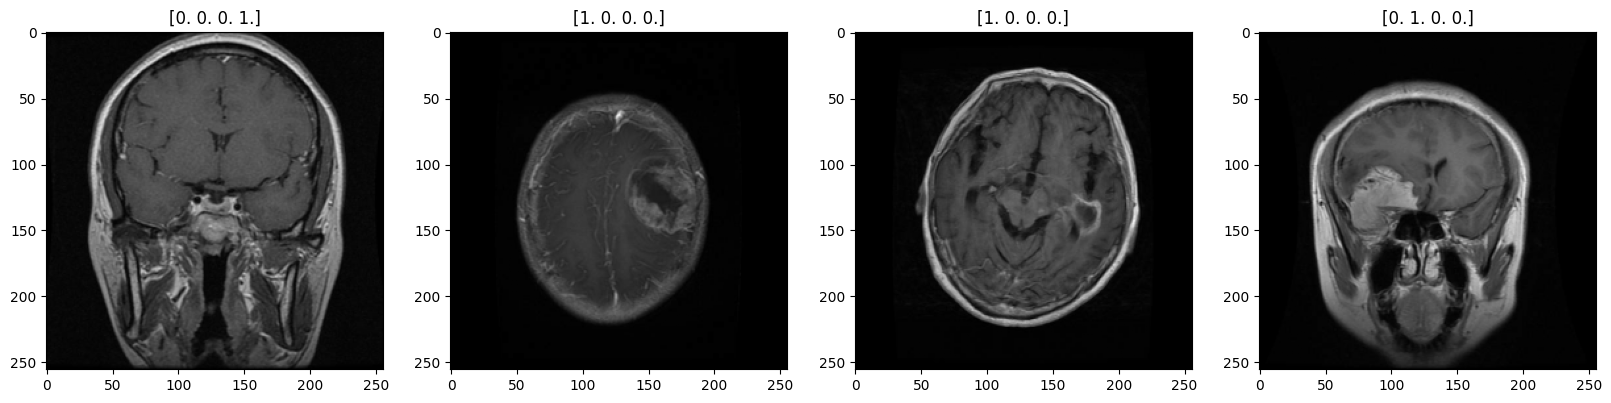

In [32]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index])
    ax[idx].title.set_text(batch_training[1][img_index])


#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


# Deep Model

In [64]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(128, activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate =0.1))

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.003)))
model.add(Dropout(rate=0.2))

model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(rate=0.2))


# Final layer that gives a single output and represets the label
model.add(Dense(4, activation = 'softmax'))

In [65]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 32)       

#### Training

In [67]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [69]:
hist = model.fit(Training_data, epochs = 20, validation_data = Validation_data, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/20
73/73 [==============================] - 23s 248ms/step - loss: 2.7509 - accuracy: 0.4558 - val_loss: 1.9937 - val_accuracy: 0.4828
Epoch 2/20
73/73 [==============================] - 17s 222ms/step - loss: 1.5639 - accuracy: 0.5404 - val_loss: 1.2884 - val_accuracy: 0.5928
Epoch 3/20
73/73 [==============================] - 16s 213ms/step - loss: 1.1838 - accuracy: 0.6125 - val_loss: 1.0320 - val_accuracy: 0.6598
Epoch 4/20
73/73 [==============================] - 18s 243ms/step - loss: 1.0143 - accuracy: 0.6817 - val_loss: 1.0072 - val_accuracy: 0.6615
Epoch 5/20
73/73 [==============================] - 21s 282ms/step - loss: 0.9286 - accuracy: 0.7096 - val_loss: 0.9410 - val_accuracy: 0.6993
Epoch 6/20
73/73 [==============================] - 16s 212ms/step - loss: 0.8706 - accuracy: 0.7418 - val_loss: 0.8730 - val_accuracy: 0.7148
Epoch 7/20
73/73 [==============================] - 17s 215ms/step - loss: 0.7965 - accuracy: 0.7680 - val_loss: 0.7979 - val_accuracy: 0.7388

In [70]:
#tf.debugging.disable_traceback_filtering()

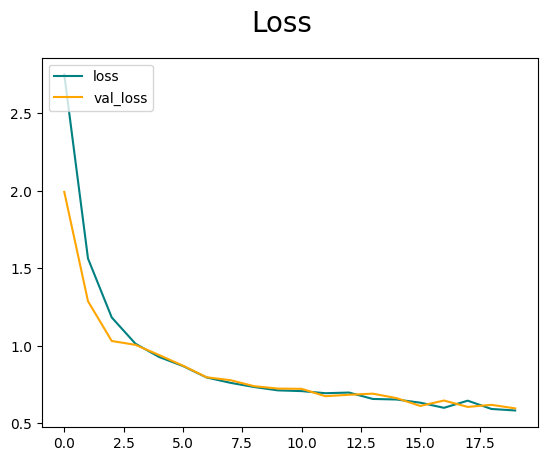

In [71]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

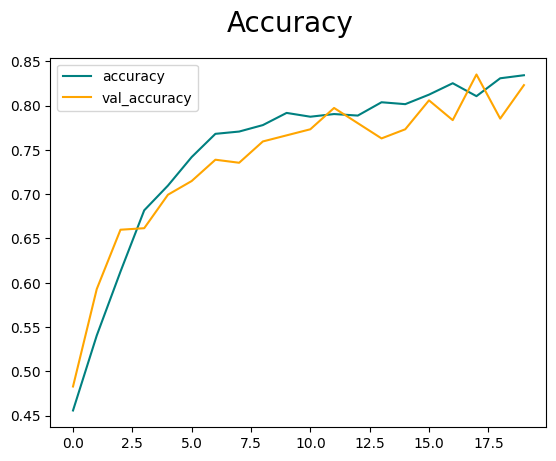

In [72]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [73]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [74]:
labels_testing = []
X_test =[]

for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch

    y_test = [np.where(row == 1)[0][0].tolist() for row in y_test]
    # Process your data here

    labels_testing.extend(y_test)
    X_test.extend(x_test)
    # Your further processing...

labels_testing = np.array(labels_testing)
X_test = np.array(X_test)

In [75]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
y_ = labels_testing # Our true y values
yhat_ =[] # Empty list for predicted variables

yhat = model.predict(X_test)

yhat_binary = np.argmax(yhat, axis=1)

yhat_.append(yhat_binary)

pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)

In [77]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.7640750408172607
Recall: 0.9693877696990967
Accuracy: 0.312182754278183


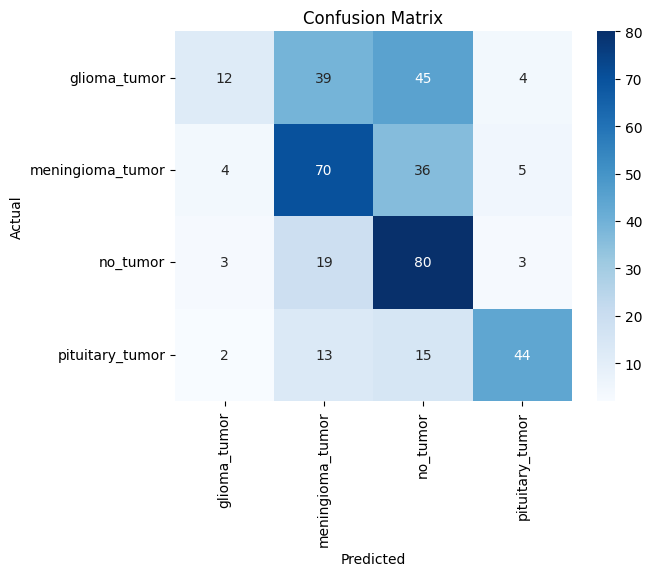

In [78]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### WE can say that while Meningioma pituitary and no tumor are being picked up, Glioma tumor isn't so easily and is often being mistaken for No tumor which is an error we cannot afford.